# __Step 4.5: Outlier analysis__

Goals here:
- Classify outliers into:
  - those that are between topics: potentially providing "inter-topic" connections.
  - those that have low probabiity for all topics, potentially:
    - Topics that are interdisciplinary with other fields


## ___Set up___

### Module import

In [32]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from bertopic import BERTopic
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_5_outlier_analysis"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus
dir25       = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = dir25 / "corpus_plant_421658.tsv.gz"

# processed docs
dir41            = proj_dir / "4_topic_model/4_1_compare_models"
docs_clean_file  = dir41 / "corpus_plant_421658_proc_txt.pkl"

# saved model, probability, and embedding files
dir42            = proj_dir / "4_topic_model/4_2_outlier_assign"
topic_model_file = dir42 / "topic_model_updated"
prob_file        = dir42 / "probs.pickle"
embedding_file   = dir42 / "embeddings_scibert.pickle"

# modified topic names
dir43            = proj_dir / "4_topic_model/4_3_model_analysis"
toc_mod_name_file= dir43 / 'fig4_3_topic_heatmap_seaborn_order_condensed.txt'

# topic overtime
dir44            = proj_dir / "4_topic_model/4_4_over_time"

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Load data___

### Load original corpus

In [3]:
df_corpus = pd.read_csv(corpus_file, sep='\t')

In [4]:
df_corpus.shape

(421658, 11)

### Load topic model and probability

In [5]:
# Load topic model
topic_model = BERTopic.load(topic_model_file)

In [6]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name
0,-1,49228,-1_plant_plants_genes_cell
1,0,895,0_allergen_allergens_pollen_ige
2,1,2917,1_medium_callus_regeneration_mgl
3,2,1098,2_dots_fluorescence_detection_carbon dots
4,3,751,3_glyphosate_resistance_herbicide_herbicides
...,...,...,...
86,85,5989,85_soil_yield_nitrogen_water
87,86,4315,86_populations_genetic_selection_inbreeding
88,87,3737,87_pollen_pollination_flowers_floral
89,88,3807,88_populations_genetic_population_species


In [7]:
# load prob
with open(prob_file, "rb") as f:
  probs = pickle.load(f)

### Load cleaned data

In [8]:
with open(docs_clean_file, "rb") as f:
  docs = pickle.load(f)

## ___Outlier probabilities___

### Get topic assignment

In [9]:
probability_threshold = np.percentile(probs, 95)
topics_assign = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]

In [50]:
probability_threshold

0.015512210159378426

In [10]:
type(probs), probs.shape, len(topics_assign)

(numpy.ndarray, (421658, 90), 421658)

In [11]:
np.unique(np.array(topics_assign))

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89])

In [12]:
outlier_idxs = [idx for idx, topic in enumerate(topics_assign) if topic == -1]
len(outlier_idxs), outlier_idxs[:10]

(49228, [36, 49, 54, 72, 112, 131, 145, 146, 162, 182])

### Get probabilities for outliers

In [13]:
probs_outliers = probs[outlier_idxs,]
probs_outliers.shape

(49228, 90)

## ___Probability heatmap___

### PCA

There are too many docs (49228). Reduce the dimensionality of the rows with PCA.

In [22]:
probs_outliers_trans = probs_outliers.transpose()
probs_outliers_trans.shape

(90, 49228)

In [29]:
pca = PCA(n_components=80)
pca.fit(probs_outliers_trans)

PCA(n_components=80)

In [30]:
probs_outliers_pca = pca.transform(probs_outliers_trans).transpose()
probs_outliers_pca.shape

(80, 90)

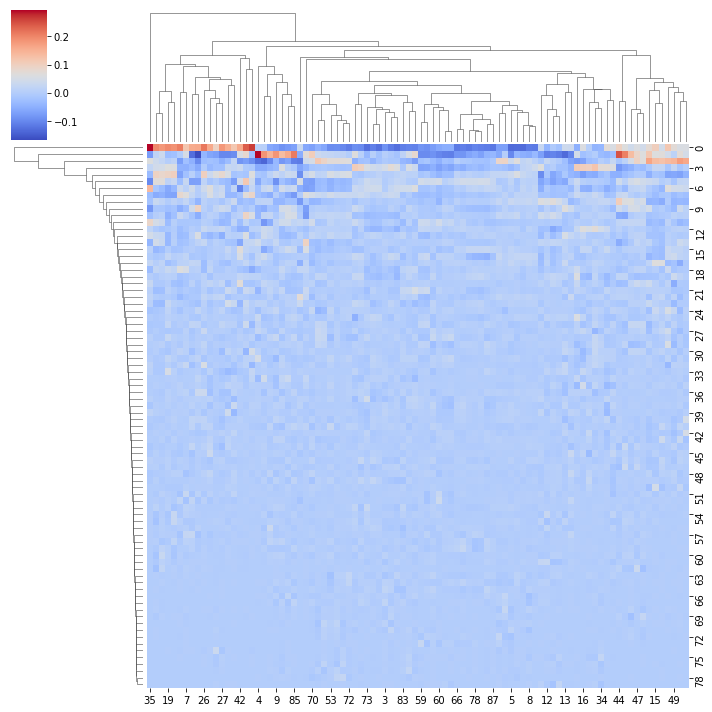

In [31]:
sns.clustermap(probs_outliers_pca, cmap='coolwarm')

### K-means

In [36]:
kmeans = KMeans(n_clusters=500, random_state=seed).fit(probs_outliers)

In [39]:
clus_centers = kmeans.cluster_centers_
clus_centers.shape

(500, 90)

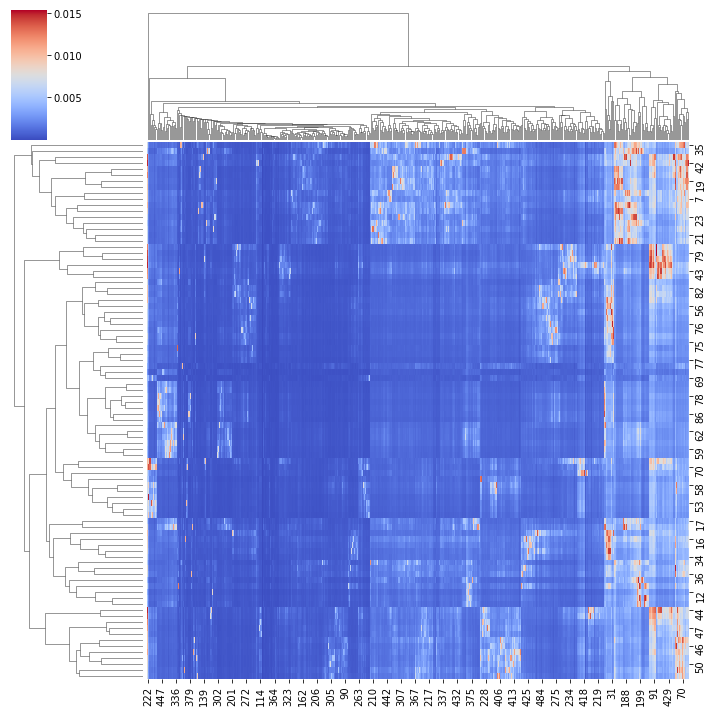

In [43]:
sns.clustermap(clus_centers.transpose(), cmap='coolwarm')

### K-means (k=100)

In [88]:
kmeans100 = KMeans(n_clusters=100, random_state=seed).fit(probs_outliers)
clus_centers100 = kmeans100.cluster_centers_.transpose()

<Figure size 1152x1036.8 with 0 Axes>

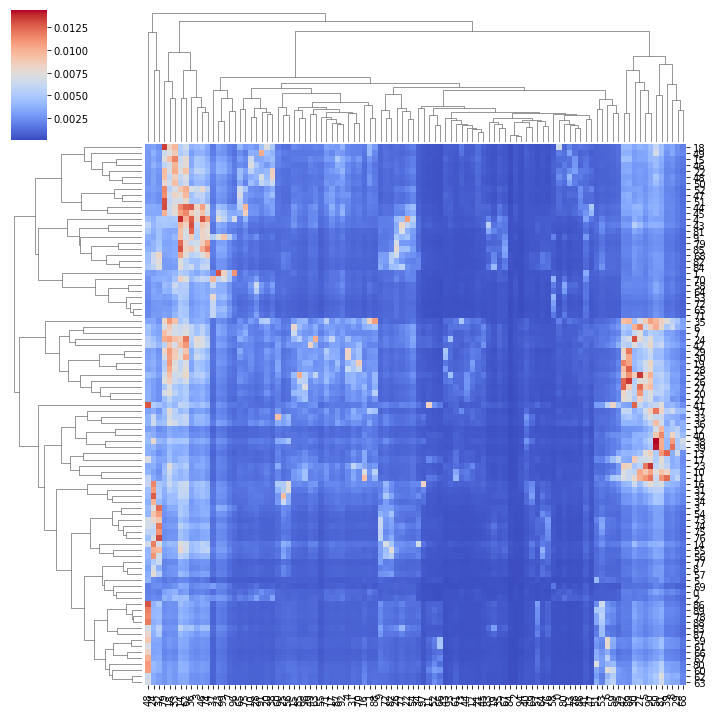

In [89]:
plt.figure(figsize=(16,14.4))
cgrid = sns.clustermap(clus_centers100, cmap='coolwarm', 
                       method='weighted', xticklabels=True, yticklabels=True,)
plt.savefig(work_dir / 'figure4_5_outlier_proba_kmeans.pdf')

### Plot cluster sizes

In [58]:
order_topics   = cgrid.dendrogram_row.reordered_ind
order_clusters = cgrid.dendrogram_col.reordered_ind

In [59]:
print(order_topics), print(order_clusters)

[18, 49, 15, 46, 22, 48, 50, 52, 47, 51, 44, 45, 4, 43, 81, 9, 79, 85, 68, 82, 84, 1, 70, 58, 64, 53, 72, 65, 71, 35, 6, 7, 24, 42, 29, 30, 19, 28, 25, 26, 27, 20, 21, 41, 37, 33, 36, 12, 40, 38, 39, 13, 17, 23, 10, 11, 16, 31, 32, 34, 3, 54, 73, 74, 75, 76, 14, 55, 56, 77, 8, 57, 5, 69, 0, 2, 86, 89, 78, 88, 83, 87, 59, 61, 66, 67, 80, 60, 62, 63]
[48, 24, 32, 79, 18, 33, 14, 62, 36, 3, 46, 74, 37, 23, 99, 7, 96, 65, 75, 10, 28, 91, 20, 38, 60, 25, 56, 15, 85, 98, 49, 63, 55, 71, 17, 87, 92, 4, 31, 70, 16, 1, 88, 9, 72, 82, 26, 77, 22, 54, 34, 97, 11, 52, 66, 43, 93, 61, 73, 44, 12, 21, 45, 83, 19, 35, 67, 84, 2, 94, 40, 69, 57, 64, 76, 58, 0, 80, 13, 78, 86, 41, 47, 51, 53, 6, 59, 95, 42, 89, 30, 27, 5, 90, 50, 81, 39, 8, 29, 68]


(None, None)

In [74]:
clus_labels100 = kmeans100.labels_
clust_sizes_np = np.unique(clus_labels100, return_counts=True)
clust_sizes_df = pd.DataFrame(clust_sizes_np).transpose()
clust_sizes_df.rename(columns={0:'ClusterID', 1:"Sizes"}, inplace=True)
clust_sizes_df.head()

,ClusterID,Sizes
0,0,208
1,1,425
2,2,3452
3,3,110
4,4,277


In [73]:
clust_sizes_df_ordered = clust_sizes_df.reindex(order_clusters)
clust_sizes_df_ordered.head()

,ClusterID,Sizes
48,48,23
24,24,73
32,32,50
79,79,38
18,18,102


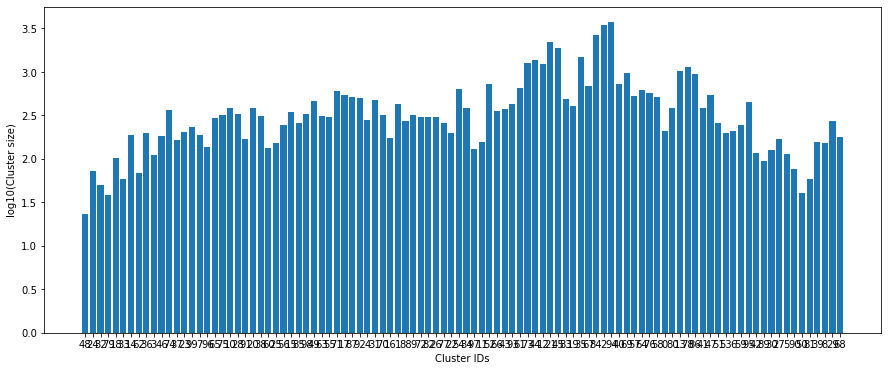

In [87]:
plt.figure(figsize=(15, 6))
plt.bar(x=range(clust_sizes_df_ordered.shape[0]),
        height=np.log10(clust_sizes_df_ordered['Sizes']),
        tick_label=list(clust_sizes_df_ordered['ClusterID']))
plt.xlabel("Cluster IDs")
plt.ylabel("log10(Cluster size)")
plt.savefig(work_dir / 'figure4_5_outlier_cluster_sizes.pdf')

## ___Code development___

### PCA testing

In [18]:
X = np.array([[-1, -1, 0], [-2, -1, 0], [-3, -2, 2], 
              [1, 1, 1], [2, 1, 1], [3, 2, -1]])
X

array([[-1, -1,  0],
       [-2, -1,  0],
       [-3, -2,  2],
       [ 1,  1,  1],
       [ 2,  1,  1],
       [ 3,  2, -1]])

In [19]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [20]:
pca.transform(X)

array([[ 1.25696897,  0.75762016],
       [ 2.0786007 ,  0.93584765],
       [ 3.83110968, -0.75632358],
       [-1.25696897, -0.75762016],
       [-2.0786007 , -0.93584765],
       [-3.83110968,  0.75632358]])

### K-means testing

In [34]:
X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])
X.shape

(6, 2)

In [35]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

array([1, 1, 1, 0, 0, 0], dtype=int32)